In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from numpy import asarray
import glob
import cv2
import tensorflow as tf
from tensorflow import keras

## Import Data

### Train.csv

In [2]:
all_labels=pd.read_csv('train.csv')

In [3]:
Labels_DF=pd.DataFrame(all_labels)
Labels_DF.rename(columns={'image':'file_name'}, inplace=True)
Labels_DF.head(3)

file_name             species individual_id
0  00021adfb725ed.jpg  melon_headed_whale  cadddb1636b9
1  000562241d384d.jpg      humpback_whale  1a71fbb72250
2  0007c33415ce37.jpg  false_killer_whale  60008f293a2b

In [4]:
#Labels_DF['species'].value_counts()

In [5]:
## species with incorrect spellings.  bottlenose_dolpin, kiler_whale.
Labels_DF['species'].replace('bottlenose_dolpin', 'bottlenose_dolphin', inplace=True)
Labels_DF['species'].replace('kiler_whale', 'killer_whale', inplace=True)

In [6]:
## create subcategory for whale or dolphin
sub=[]
for each in Labels_DF['species']:
    if 'dolphin' in each:
        a=0
    else: a=1
    sub.append(a)

In [7]:
Labels_DF['sub_cat']=sub

In [8]:
## create species cat numerical
from sklearn.preprocessing import OrdinalEncoder
OE=OrdinalEncoder()
SE=OE.fit_transform(Labels_DF[['species']])
Labels_DF['species_category']=SE.astype(int)

In [9]:
Labels_DF.head(6)

file_name             species individual_id  sub_cat  \
0  00021adfb725ed.jpg  melon_headed_whale  cadddb1636b9        1   
1  000562241d384d.jpg      humpback_whale  1a71fbb72250        1   
2  0007c33415ce37.jpg  false_killer_whale  60008f293a2b        1   
3  0007d9bca26a99.jpg  bottlenose_dolphin  4b00fe572063        0   
4  00087baf5cef7a.jpg      humpback_whale  8e5253662392        1   
5  000a8f2d5c316a.jpg  bottlenose_dolphin  b9907151f66e        0   

   species_category  
0                16  
1                13  
2                 8  
3                 2  
4                13  
5                 2

In [10]:
len(Labels_DF['species_category'].value_counts())

28

In [11]:
Labels_DF['species_category'].value_counts()

2     10781
0      7443
13     7392
1      4830
8      3326
7      3139
14     2455
25     1700
16     1689
17     1608
9      1324
12     1123
24      866
26      490
22      428
23      367
5       347
6       341
19      262
15      238
27      229
3       154
18      145
11      116
4        90
20       76
21       60
10       14
Name: species_category, dtype: int64

In [12]:
Species_Key=pd.DataFrame({
    'Species': Labels_DF['species'].unique(),
    'Key': Labels_DF['species_category'].unique()
})

In [13]:
Species_Key

Species  Key
0          melon_headed_whale   16
1              humpback_whale   13
2          false_killer_whale    8
3          bottlenose_dolphin    2
4                      beluga    0
5                 minke_whale   17
6                   fin_whale    9
7                  blue_whale    1
8                  gray_whale   12
9        southern_right_whale   24
10             common_dolphin    5
11               killer_whale   14
12                pilot_whale   19
13              dusky_dolphin    7
14    long_finned_pilot_whale   15
15                  sei_whale   22
16            spinner_dolphin   25
17       cuviers_beaked_whale    6
18            spotted_dolphin   26
19                     globis   11
20               brydes_whale    3
21         commersons_dolphin    4
22        white_sided_dolphin   27
23   short_finned_pilot_whale   23
24      rough_toothed_dolphin   21
25  pantropic_spotted_dolphin   18
26         pygmy_killer_whale   20
27           frasiers_dolphin   10

### Images

In [14]:
# get images
image_list = []
for filename in glob.glob('SmallSample/*.jpg'):
    im=Image.open(filename)
    image_list.append(im)

In [15]:
# file name for each image
image_names = []
for filename in glob.glob('SmallSample/*.jpg'):
    name=filename.strip('SmallSample\\')
    image_names.append(name)

In [16]:
len(image_list), len(image_names)

(152, 152)

In [17]:
Image_DF=pd.DataFrame({
    'image': image_list,
    'file_name': image_names
    })

In [18]:
## Join Dataframes

Big_DF=Image_DF.merge(Labels_DF, how='outer')

In [19]:
Big_DF=Big_DF[:152]
Big_DF.tail(5)

image           file_name  \
147  <PIL.JpegImagePlugin.JpegImageFile image mode=...  0a99ad33a87739.jpg   
148  <PIL.JpegImagePlugin.JpegImageFile image mode=...  0a99cbb091b9b8.jpg   
149  <PIL.JpegImagePlugin.JpegImageFile image mode=...  0a9c11c6d8d9e6.jpg   
150  <PIL.JpegImagePlugin.JpegImageFile image mode=...  0a9daef82ebe79.jpg   
151  <PIL.JpegImagePlugin.JpegImageFile image mode=...  0a9f092e4e3e92.jpg   

            species individual_id  sub_cat  species_category  
147      blue_whale  ea1dbc9f1f36        1                 1  
148  humpback_whale  d1f90ae774ca        1                13  
149  humpback_whale  f70cb8952cad        1                13  
150   dusky_dolphin  62ac9c194888        0                 7  
151  humpback_whale  51ccb281b87c        1                13

### Create train/val Dataset

#### Shuffle and split dataset

In [20]:
from sklearn.model_selection import train_test_split

y=Big_DF['sub_cat']
X=Big_DF['image']

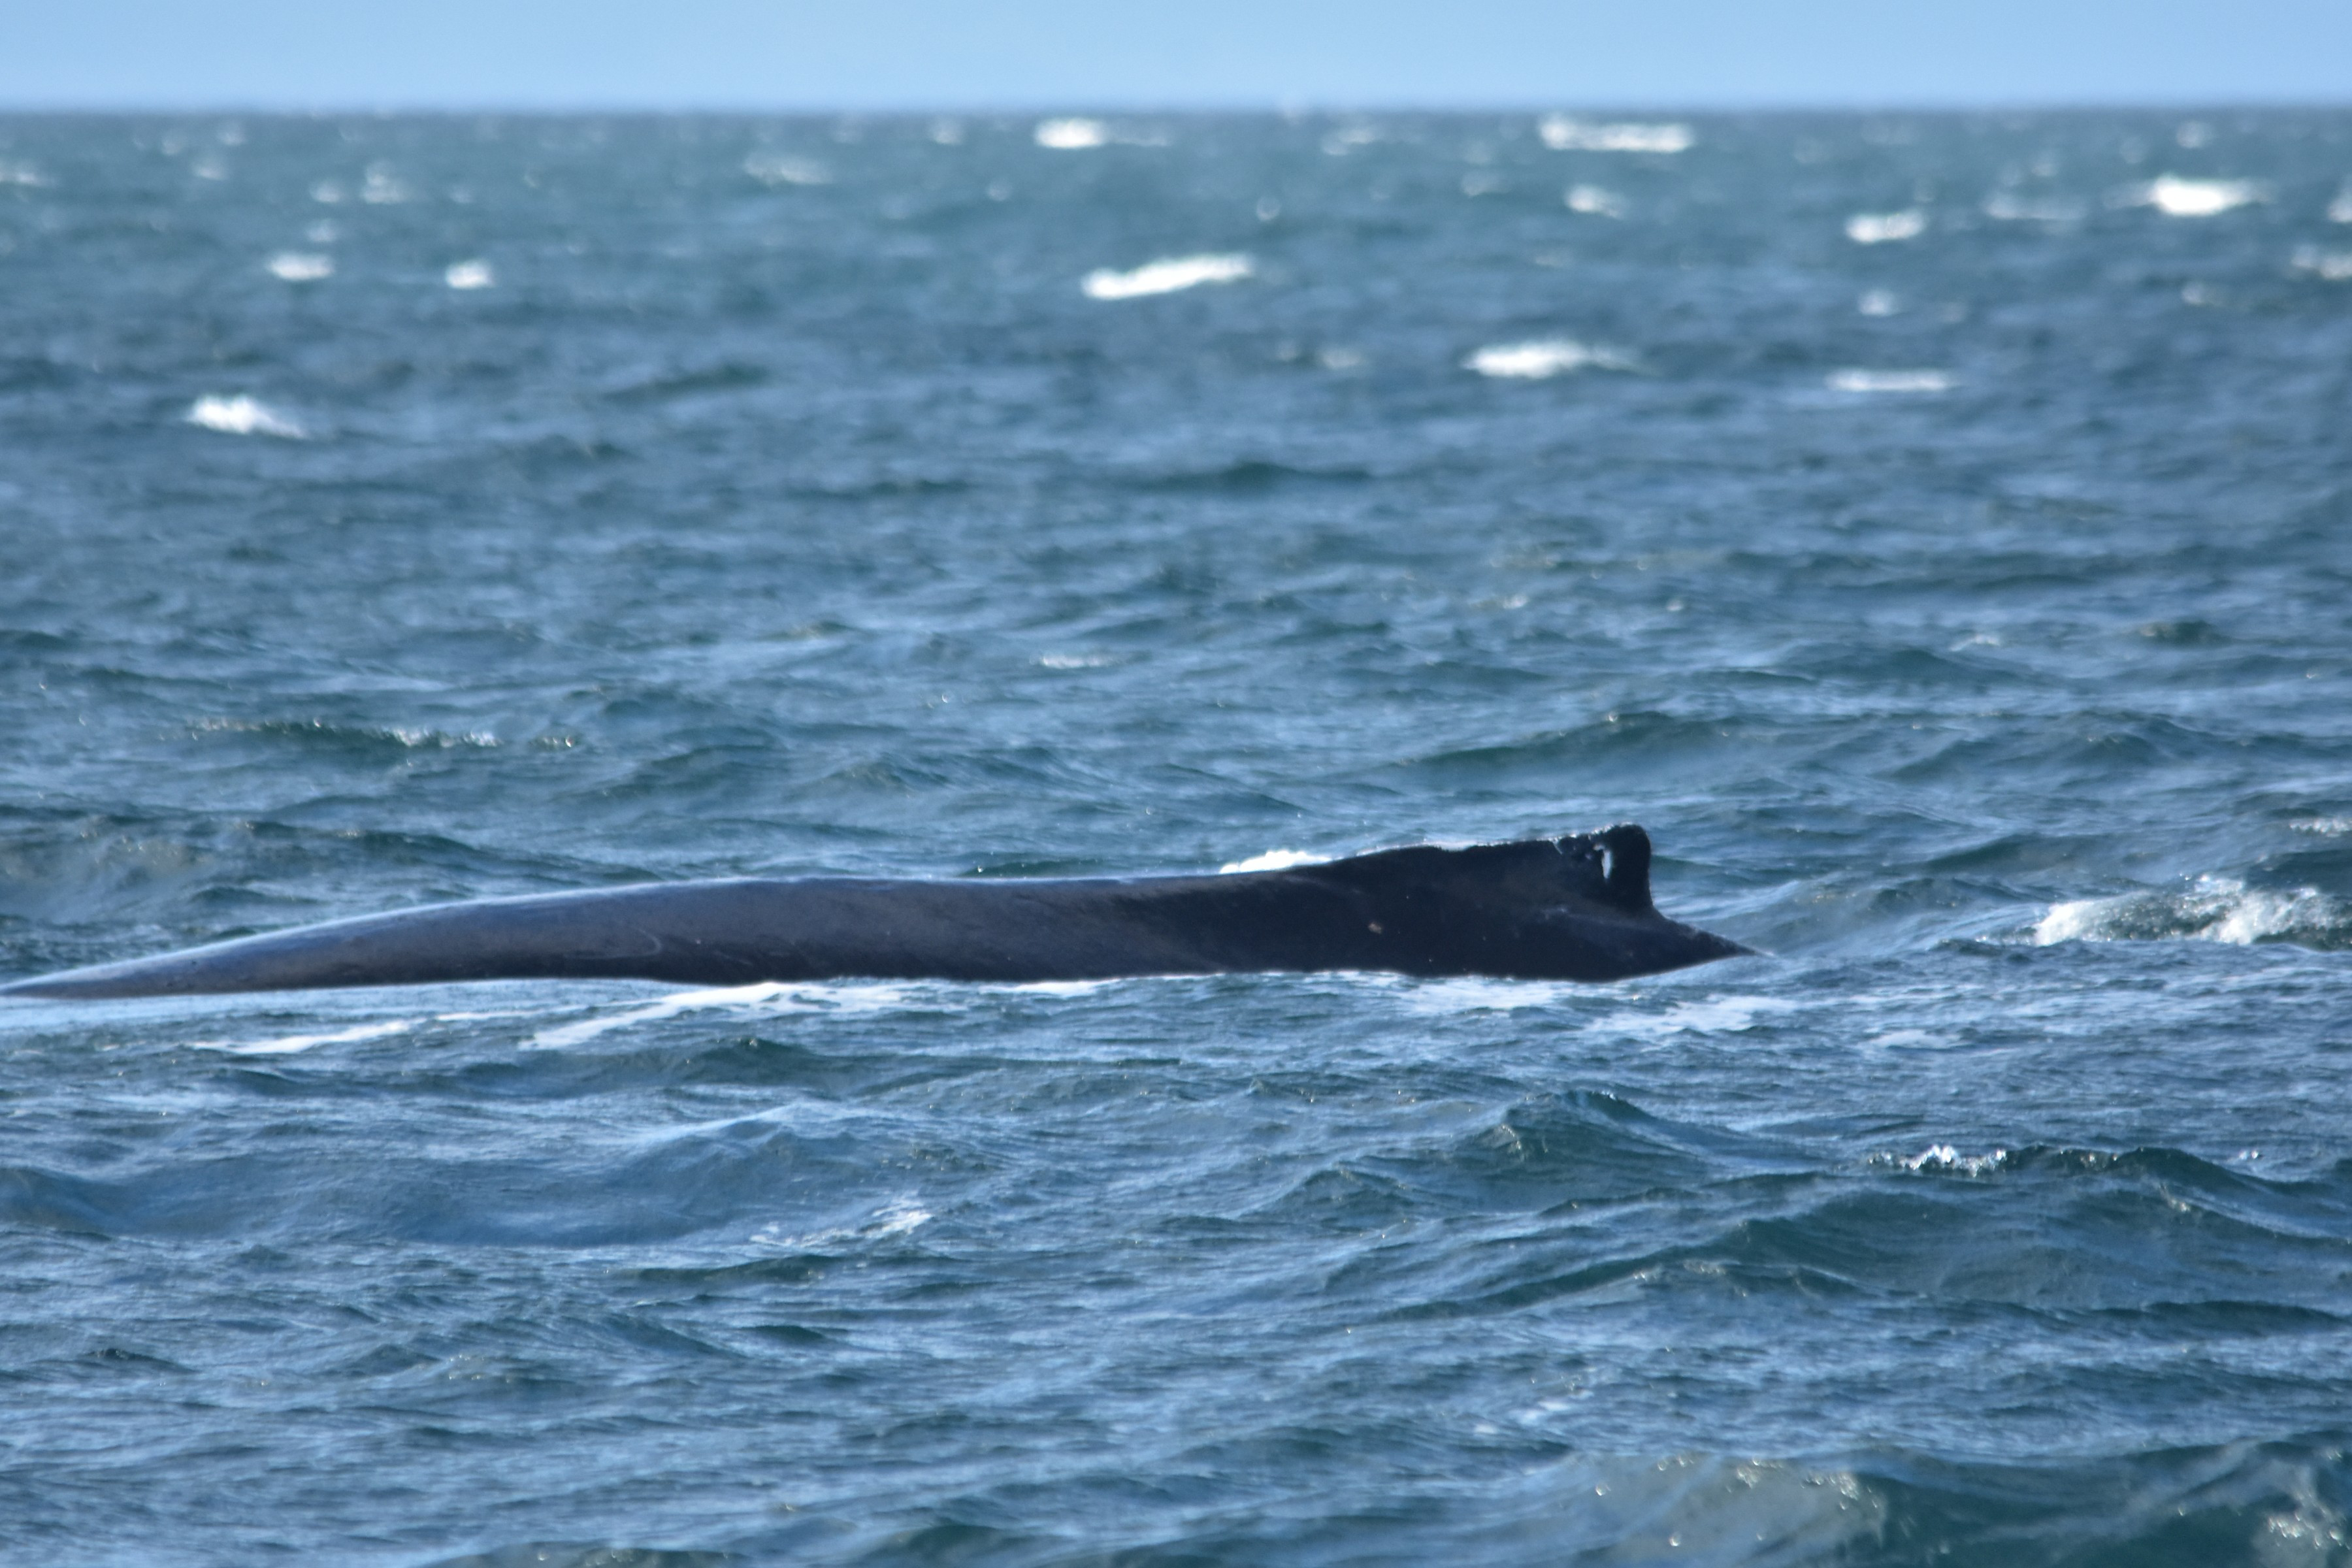

In [21]:
X[2]

In [22]:
for each in X:
    each.thumbnail((150,150))

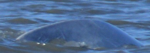

In [23]:
X[3]

In [24]:
from PIL import ImageOps
reshaped_img=[]
size=(200,150)

for each in X:
    i=ImageOps.fit(each, size, Image.ANTIALIAS)
    reshaped_img.append(i)
    

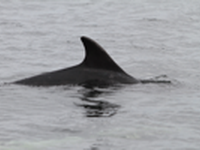

In [50]:
reshaped_img[18]

### Convert to grayscale

In [57]:
import cv2

reshaped_gray=[]

for each in reshaped_img:
    g=each.convert(mode='L')
    reshaped_gray.append(g)

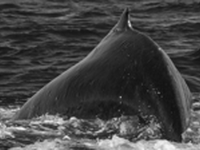

In [58]:
reshaped_gray[5]

### Convert images to arrays and normalize pixels

In [60]:
arrays=[]

for each in reshaped_gray:
    a=asarray(each)
    arrays.append(a)

In [61]:
norm_arrays=[]

for each in arrays:
    e=each/255
    norm_arrays.append(e)

In [65]:
norm_arrays[23].shape

(150, 200)

In [66]:
# One hot encode labels

from keras.utils import to_categorical

y_hot=to_categorical(y)

y_hot[:6]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [67]:
X_train, X_val, y_train, y_val= train_test_split(norm_arrays,y_hot, train_size=.80, stratify=y)

## Data Prep

In [68]:
y_train.shape, len(X_train)

((121, 2), 121)

In [69]:
X_array=np.array(X_train)

In [83]:
X_array=X_array.reshape(-1, 150, 200, 1)
X_array.shape

(121, 150, 200, 1)

In [84]:
from tensorflow.keras import layers
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

model = keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(150,200,1),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(30000, activation='linear'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(2, activation='softmax'))

In [85]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
model.fit(X_array, y_train,batch_size=30, epochs=5)

Epoch 1/5


KeyboardInterrupt: 

## Separate Dolphins into species of Dolphin

In [ ]:
Dolphins_Species=pd.DataFrame(Labels_DF.loc[Labels_DF['sub_cat']==1])

In [ ]:
Dolphins_Species['species_category'].value_counts()

#### Consider combining categories with low counts for better training when trying to identify individuals

In [ ]:
len(Labels_DF['individual_id'].unique())

####  15,587 unique individuals in entire data set (dolphins and whales) 51,000 images.  Cannot make individual id files.
####  Species category 10 has 13 unique individuals out of 14 instances.